In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('JPEGImages', 'Annotations')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco.py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'lotte_data/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'lotte_data/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/JPEGImages'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'lotte_data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/JPEGImages'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'lotte_data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/JPEGImages'

# num classes of the model in box head
for i, head in enumerate(cfg.model.roi_head.bbox_head):
    cfg.model.roi_head.bbox_head[i].num_classes = 22
# cfg.load_from = 'checkpoints/cascade_rcnn_r50_rfp_1x_coco-8cf51bfd.pth'
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CascadeRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(
 

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-09-27 17:26:55,798 - mmdet - INFO - load model from: torchvision://resnet50
2020-09-27 17:26:55,923 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-09-27 17:27:03,686 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-09-27 17:27:03,686 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs
2020-09-27 17:27:11,079 - mmdet - INFO - Epoch [1][10/587]	lr: 2.500e-03, eta: 1:25:28, time: 0.729, data_time: 0.212, memory: 4109, loss_rpn_cls: 0.4867, loss_rpn_bbox: 0.0591, s0.loss_cls: 1.1108, s0.acc: 82.8711, s0.loss_bbox: 0.1563, s1.loss_cls: 0.5429, s1.acc: 82.9004, s1.loss_bbox: 0.0501, s2.loss_cls: 0.2563, s2.acc: 85.8398, s2.loss_bbox: 0.0075, loss: 2.6698
2020-09-27 17:27:16,183 - mmdet - INFO - Epoch [1][20/587]	lr: 2.500e-03, eta: 1:12:31, time: 0.510, data_time: 0.013, memory: 4109, loss_rpn_cls: 

2020-09-27 17:28:57,457 - mmdet - INFO - Epoch [1][220/587]	lr: 2.500e-03, eta: 0:58:45, time: 0.486, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0208, loss_rpn_bbox: 0.0317, s0.loss_cls: 0.7698, s0.acc: 79.1602, s0.loss_bbox: 0.1984, s1.loss_cls: 0.3883, s1.acc: 79.0020, s1.loss_bbox: 0.2201, s2.loss_cls: 0.2158, s2.acc: 77.1327, s2.loss_bbox: 0.1636, loss: 2.0083
2020-09-27 17:29:02,600 - mmdet - INFO - Epoch [1][230/587]	lr: 2.500e-03, eta: 0:58:39, time: 0.513, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0252, loss_rpn_bbox: 0.0307, s0.loss_cls: 0.8206, s0.acc: 79.5898, s0.loss_bbox: 0.2033, s1.loss_cls: 0.4262, s1.acc: 78.0983, s1.loss_bbox: 0.2231, s2.loss_cls: 0.2320, s2.acc: 77.4008, s2.loss_bbox: 0.1653, loss: 2.1265
2020-09-27 17:29:07,721 - mmdet - INFO - Epoch [1][240/587]	lr: 2.500e-03, eta: 0:58:33, time: 0.515, data_time: 0.015, memory: 4109, loss_rpn_cls: 0.0233, loss_rpn_bbox: 0.0305, s0.loss_cls: 0.7099, s0.acc: 80.4688, s0.loss_bbox: 0.1804, s1.loss_cls: 0.37

2020-09-27 17:30:54,923 - mmdet - INFO - Epoch [1][450/587]	lr: 2.500e-03, eta: 0:56:26, time: 0.514, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0129, loss_rpn_bbox: 0.0263, s0.loss_cls: 0.4310, s0.acc: 89.3262, s0.loss_bbox: 0.1834, s1.loss_cls: 0.2258, s1.acc: 90.9534, s1.loss_bbox: 0.1835, s2.loss_cls: 0.1278, s2.acc: 89.1697, s2.loss_bbox: 0.1373, loss: 1.3280
2020-09-27 17:30:59,931 - mmdet - INFO - Epoch [1][460/587]	lr: 2.500e-03, eta: 0:56:20, time: 0.503, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0181, loss_rpn_bbox: 0.0231, s0.loss_cls: 0.3254, s0.acc: 90.5566, s0.loss_bbox: 0.1712, s1.loss_cls: 0.1563, s1.acc: 91.7286, s1.loss_bbox: 0.1731, s2.loss_cls: 0.0913, s2.acc: 90.5035, s2.loss_bbox: 0.1358, loss: 1.0943
2020-09-27 17:31:05,132 - mmdet - INFO - Epoch [1][470/587]	lr: 2.500e-03, eta: 0:56:15, time: 0.520, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0152, loss_rpn_bbox: 0.0230, s0.loss_cls: 0.3859, s0.acc: 90.2930, s0.loss_bbox: 0.1701, s1.loss_cls: 0.17

2020-09-27 17:32:57,383 - mmdet - INFO - Epoch [2][100/587]	lr: 2.500e-03, eta: 0:53:59, time: 0.513, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0068, loss_rpn_bbox: 0.0194, s0.loss_cls: 0.2411, s0.acc: 93.5645, s0.loss_bbox: 0.1316, s1.loss_cls: 0.1180, s1.acc: 95.2419, s1.loss_bbox: 0.1355, s2.loss_cls: 0.0632, s2.acc: 95.4662, s2.loss_bbox: 0.1152, loss: 0.8308
2020-09-27 17:33:02,358 - mmdet - INFO - Epoch [2][110/587]	lr: 2.500e-03, eta: 0:53:53, time: 0.498, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0098, loss_rpn_bbox: 0.0203, s0.loss_cls: 0.2407, s0.acc: 92.2949, s0.loss_bbox: 0.1102, s1.loss_cls: 0.1098, s1.acc: 93.4738, s1.loss_bbox: 0.1242, s2.loss_cls: 0.0602, s2.acc: 93.3489, s2.loss_bbox: 0.1003, loss: 0.7756
2020-09-27 17:33:07,416 - mmdet - INFO - Epoch [2][120/587]	lr: 2.500e-03, eta: 0:53:47, time: 0.506, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0076, loss_rpn_bbox: 0.0217, s0.loss_cls: 0.2324, s0.acc: 93.3203, s0.loss_bbox: 0.1208, s1.loss_cls: 0.10

2020-09-27 17:34:53,202 - mmdet - INFO - Epoch [2][330/587]	lr: 2.500e-03, eta: 0:51:52, time: 0.504, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0070, loss_rpn_bbox: 0.0180, s0.loss_cls: 0.1714, s0.acc: 94.5898, s0.loss_bbox: 0.1112, s1.loss_cls: 0.0670, s1.acc: 96.5429, s1.loss_bbox: 0.1216, s2.loss_cls: 0.0370, s2.acc: 96.0563, s2.loss_bbox: 0.0973, loss: 0.6305
2020-09-27 17:34:58,239 - mmdet - INFO - Epoch [2][340/587]	lr: 2.500e-03, eta: 0:51:47, time: 0.502, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0066, loss_rpn_bbox: 0.0172, s0.loss_cls: 0.1881, s0.acc: 94.8438, s0.loss_bbox: 0.1007, s1.loss_cls: 0.0880, s1.acc: 96.1894, s1.loss_bbox: 0.1158, s2.loss_cls: 0.0470, s2.acc: 96.2417, s2.loss_bbox: 0.1023, loss: 0.6656
2020-09-27 17:35:03,189 - mmdet - INFO - Epoch [2][350/587]	lr: 2.500e-03, eta: 0:51:41, time: 0.496, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0053, loss_rpn_bbox: 0.0166, s0.loss_cls: 0.1698, s0.acc: 94.7070, s0.loss_bbox: 0.1125, s1.loss_cls: 0.07

2020-09-27 17:36:49,604 - mmdet - INFO - Epoch [2][560/587]	lr: 2.500e-03, eta: 0:49:53, time: 0.496, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0056, loss_rpn_bbox: 0.0157, s0.loss_cls: 0.1747, s0.acc: 95.1660, s0.loss_bbox: 0.0982, s1.loss_cls: 0.0799, s1.acc: 96.7817, s1.loss_bbox: 0.1244, s2.loss_cls: 0.0449, s2.acc: 96.7759, s2.loss_bbox: 0.1102, loss: 0.6534
2020-09-27 17:36:54,691 - mmdet - INFO - Epoch [2][570/587]	lr: 2.500e-03, eta: 0:49:48, time: 0.509, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0059, loss_rpn_bbox: 0.0179, s0.loss_cls: 0.2336, s0.acc: 94.9414, s0.loss_bbox: 0.0882, s1.loss_cls: 0.1312, s1.acc: 95.8703, s1.loss_bbox: 0.1152, s2.loss_cls: 0.0770, s2.acc: 95.7127, s2.loss_bbox: 0.1031, loss: 0.7720
2020-09-27 17:36:59,667 - mmdet - INFO - Epoch [2][580/587]	lr: 2.500e-03, eta: 0:49:43, time: 0.498, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0057, loss_rpn_bbox: 0.0152, s0.loss_cls: 0.1506, s0.acc: 95.3320, s0.loss_bbox: 0.0970, s1.loss_cls: 0.06

2020-09-27 17:38:51,256 - mmdet - INFO - Epoch [3][210/587]	lr: 2.500e-03, eta: 0:47:44, time: 0.507, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0135, s0.loss_cls: 0.1385, s0.acc: 95.6738, s0.loss_bbox: 0.0832, s1.loss_cls: 0.0692, s1.acc: 96.5983, s1.loss_bbox: 0.1069, s2.loss_cls: 0.0382, s2.acc: 96.5285, s2.loss_bbox: 0.0938, loss: 0.5492
2020-09-27 17:38:56,312 - mmdet - INFO - Epoch [3][220/587]	lr: 2.500e-03, eta: 0:47:39, time: 0.506, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0158, s0.loss_cls: 0.1465, s0.acc: 95.4102, s0.loss_bbox: 0.0773, s1.loss_cls: 0.0681, s1.acc: 97.1118, s1.loss_bbox: 0.1022, s2.loss_cls: 0.0399, s2.acc: 97.1656, s2.loss_bbox: 0.0947, loss: 0.5483
2020-09-27 17:39:01,572 - mmdet - INFO - Epoch [3][230/587]	lr: 2.500e-03, eta: 0:47:34, time: 0.524, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0078, loss_rpn_bbox: 0.0176, s0.loss_cls: 0.1843, s0.acc: 95.5078, s0.loss_bbox: 0.0921, s1.loss_cls: 0.09

2020-09-27 17:40:46,910 - mmdet - INFO - Epoch [3][440/587]	lr: 2.500e-03, eta: 0:45:45, time: 0.487, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0056, loss_rpn_bbox: 0.0122, s0.loss_cls: 0.1062, s0.acc: 96.3184, s0.loss_bbox: 0.0689, s1.loss_cls: 0.0392, s1.acc: 97.6602, s1.loss_bbox: 0.0950, s2.loss_cls: 0.0204, s2.acc: 97.9713, s2.loss_bbox: 0.0876, loss: 0.4350
2020-09-27 17:40:51,964 - mmdet - INFO - Epoch [3][450/587]	lr: 2.500e-03, eta: 0:45:40, time: 0.505, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0062, loss_rpn_bbox: 0.0149, s0.loss_cls: 0.1297, s0.acc: 95.9375, s0.loss_bbox: 0.0828, s1.loss_cls: 0.0693, s1.acc: 97.2222, s1.loss_bbox: 0.1071, s2.loss_cls: 0.0393, s2.acc: 97.5792, s2.loss_bbox: 0.0932, loss: 0.5426
2020-09-27 17:40:57,013 - mmdet - INFO - Epoch [3][460/587]	lr: 2.500e-03, eta: 0:45:35, time: 0.505, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0119, s0.loss_cls: 0.1712, s0.acc: 94.9512, s0.loss_bbox: 0.0803, s1.loss_cls: 0.09

2020-09-27 17:42:48,204 - mmdet - INFO - Epoch [4][90/587]	lr: 2.500e-03, eta: 0:43:39, time: 0.500, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0117, s0.loss_cls: 0.1399, s0.acc: 95.7031, s0.loss_bbox: 0.0757, s1.loss_cls: 0.0830, s1.acc: 96.6366, s1.loss_bbox: 0.1034, s2.loss_cls: 0.0498, s2.acc: 97.0655, s2.loss_bbox: 0.0967, loss: 0.5655
2020-09-27 17:42:53,218 - mmdet - INFO - Epoch [4][100/587]	lr: 2.500e-03, eta: 0:43:34, time: 0.503, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0103, s0.loss_cls: 0.1232, s0.acc: 95.8203, s0.loss_bbox: 0.0594, s1.loss_cls: 0.0678, s1.acc: 97.8452, s1.loss_bbox: 0.0773, s2.loss_cls: 0.0416, s2.acc: 97.9143, s2.loss_bbox: 0.0702, loss: 0.4540
2020-09-27 17:42:58,343 - mmdet - INFO - Epoch [4][110/587]	lr: 2.500e-03, eta: 0:43:29, time: 0.513, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0138, s0.loss_cls: 0.1451, s0.acc: 95.7520, s0.loss_bbox: 0.0709, s1.loss_cls: 0.103

2020-09-27 17:44:44,215 - mmdet - INFO - Epoch [4][320/587]	lr: 2.500e-03, eta: 0:41:43, time: 0.513, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0130, s0.loss_cls: 0.1414, s0.acc: 95.9180, s0.loss_bbox: 0.0773, s1.loss_cls: 0.1335, s1.acc: 97.4924, s1.loss_bbox: 0.0980, s2.loss_cls: 0.0931, s2.acc: 98.0170, s2.loss_bbox: 0.0889, loss: 0.6489
2020-09-27 17:44:49,192 - mmdet - INFO - Epoch [4][330/587]	lr: 2.500e-03, eta: 0:41:38, time: 0.498, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0108, s0.loss_cls: 0.1213, s0.acc: 96.0547, s0.loss_bbox: 0.0703, s1.loss_cls: 0.0803, s1.acc: 97.9014, s1.loss_bbox: 0.0914, s2.loss_cls: 0.0570, s2.acc: 97.8501, s2.loss_bbox: 0.0857, loss: 0.5202
2020-09-27 17:44:54,062 - mmdet - INFO - Epoch [4][340/587]	lr: 2.500e-03, eta: 0:41:32, time: 0.487, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0098, s0.loss_cls: 0.0975, s0.acc: 96.4062, s0.loss_bbox: 0.0640, s1.loss_cls: 0.03

2020-09-27 17:46:39,799 - mmdet - INFO - Epoch [4][550/587]	lr: 2.500e-03, eta: 0:39:46, time: 0.505, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0124, s0.loss_cls: 0.1315, s0.acc: 95.7324, s0.loss_bbox: 0.0733, s1.loss_cls: 0.0814, s1.acc: 97.2092, s1.loss_bbox: 0.0924, s2.loss_cls: 0.0557, s2.acc: 97.5085, s2.loss_bbox: 0.0898, loss: 0.5394
2020-09-27 17:46:44,778 - mmdet - INFO - Epoch [4][560/587]	lr: 2.500e-03, eta: 0:39:41, time: 0.498, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0104, s0.loss_cls: 0.1195, s0.acc: 95.9473, s0.loss_bbox: 0.0769, s1.loss_cls: 0.0509, s1.acc: 97.8415, s1.loss_bbox: 0.0776, s2.loss_cls: 0.0318, s2.acc: 98.3949, s2.loss_bbox: 0.0698, loss: 0.4405
2020-09-27 17:46:49,820 - mmdet - INFO - Epoch [4][570/587]	lr: 2.500e-03, eta: 0:39:36, time: 0.504, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0097, s0.loss_cls: 0.0909, s0.acc: 96.7480, s0.loss_bbox: 0.0651, s1.loss_cls: 0.05

2020-09-27 17:48:41,560 - mmdet - INFO - Epoch [5][200/587]	lr: 2.500e-03, eta: 0:37:44, time: 0.496, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0096, s0.loss_cls: 0.0875, s0.acc: 96.8555, s0.loss_bbox: 0.0710, s1.loss_cls: 0.0386, s1.acc: 98.0481, s1.loss_bbox: 0.0793, s2.loss_cls: 0.0277, s2.acc: 97.8743, s2.loss_bbox: 0.0744, loss: 0.3907
2020-09-27 17:48:46,543 - mmdet - INFO - Epoch [5][210/587]	lr: 2.500e-03, eta: 0:37:39, time: 0.500, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0118, s0.loss_cls: 0.1120, s0.acc: 95.8691, s0.loss_bbox: 0.0759, s1.loss_cls: 0.0510, s1.acc: 97.2977, s1.loss_bbox: 0.0864, s2.loss_cls: 0.0319, s2.acc: 97.3897, s2.loss_bbox: 0.0797, loss: 0.4522
2020-09-27 17:48:51,594 - mmdet - INFO - Epoch [5][220/587]	lr: 2.500e-03, eta: 0:37:34, time: 0.503, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0114, s0.loss_cls: 0.1173, s0.acc: 95.9473, s0.loss_bbox: 0.0723, s1.loss_cls: 0.05

2020-09-27 17:50:37,606 - mmdet - INFO - Epoch [5][430/587]	lr: 2.500e-03, eta: 0:35:49, time: 0.491, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0097, s0.loss_cls: 0.0798, s0.acc: 96.8750, s0.loss_bbox: 0.0511, s1.loss_cls: 0.0302, s1.acc: 98.3563, s1.loss_bbox: 0.0699, s2.loss_cls: 0.0200, s2.acc: 98.2253, s2.loss_bbox: 0.0711, loss: 0.3343
2020-09-27 17:50:42,745 - mmdet - INFO - Epoch [5][440/587]	lr: 2.500e-03, eta: 0:35:44, time: 0.512, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0094, s0.loss_cls: 0.1094, s0.acc: 96.3184, s0.loss_bbox: 0.0501, s1.loss_cls: 0.0514, s1.acc: 97.4975, s1.loss_bbox: 0.0606, s2.loss_cls: 0.0341, s2.acc: 98.3265, s2.loss_bbox: 0.0581, loss: 0.3774
2020-09-27 17:50:47,772 - mmdet - INFO - Epoch [5][450/587]	lr: 2.500e-03, eta: 0:35:39, time: 0.505, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0131, s0.loss_cls: 0.0912, s0.acc: 96.8164, s0.loss_bbox: 0.0520, s1.loss_cls: 0.04

2020-09-27 17:52:39,228 - mmdet - INFO - Epoch [6][80/587]	lr: 2.500e-03, eta: 0:33:48, time: 0.492, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0084, s0.loss_cls: 0.0900, s0.acc: 96.7578, s0.loss_bbox: 0.0489, s1.loss_cls: 0.0359, s1.acc: 97.9467, s1.loss_bbox: 0.0660, s2.loss_cls: 0.0255, s2.acc: 97.7662, s2.loss_bbox: 0.0624, loss: 0.3395
2020-09-27 17:52:44,207 - mmdet - INFO - Epoch [6][90/587]	lr: 2.500e-03, eta: 0:33:42, time: 0.498, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0084, s0.loss_cls: 0.0947, s0.acc: 97.1191, s0.loss_bbox: 0.0468, s1.loss_cls: 0.0434, s1.acc: 98.0442, s1.loss_bbox: 0.0685, s2.loss_cls: 0.0332, s2.acc: 97.9940, s2.loss_bbox: 0.0706, loss: 0.3699
2020-09-27 17:52:49,171 - mmdet - INFO - Epoch [6][100/587]	lr: 2.500e-03, eta: 0:33:37, time: 0.496, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0076, s0.loss_cls: 0.0891, s0.acc: 96.7578, s0.loss_bbox: 0.0489, s1.loss_cls: 0.0349

2020-09-27 17:54:35,778 - mmdet - INFO - Epoch [6][310/587]	lr: 2.500e-03, eta: 0:31:53, time: 0.551, data_time: 0.015, memory: 4109, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0094, s0.loss_cls: 0.1090, s0.acc: 96.4551, s0.loss_bbox: 0.0611, s1.loss_cls: 0.0420, s1.acc: 97.8543, s1.loss_bbox: 0.0804, s2.loss_cls: 0.0356, s2.acc: 98.0902, s2.loss_bbox: 0.0730, loss: 0.4129
2020-09-27 17:54:40,881 - mmdet - INFO - Epoch [6][320/587]	lr: 2.500e-03, eta: 0:31:48, time: 0.509, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0078, s0.loss_cls: 0.0862, s0.acc: 96.9336, s0.loss_bbox: 0.0526, s1.loss_cls: 0.0308, s1.acc: 98.1257, s1.loss_bbox: 0.0711, s2.loss_cls: 0.0201, s2.acc: 98.3088, s2.loss_bbox: 0.0672, loss: 0.3396
2020-09-27 17:54:45,846 - mmdet - INFO - Epoch [6][330/587]	lr: 2.500e-03, eta: 0:31:43, time: 0.498, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0090, s0.loss_cls: 0.0747, s0.acc: 97.4316, s0.loss_bbox: 0.0532, s1.loss_cls: 0.02

2020-09-27 17:56:32,034 - mmdet - INFO - Epoch [6][540/587]	lr: 2.500e-03, eta: 0:29:57, time: 0.511, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0087, s0.loss_cls: 0.0931, s0.acc: 96.2598, s0.loss_bbox: 0.0528, s1.loss_cls: 0.0329, s1.acc: 97.9208, s1.loss_bbox: 0.0694, s2.loss_cls: 0.0288, s2.acc: 98.0057, s2.loss_bbox: 0.0726, loss: 0.3619
2020-09-27 17:56:37,063 - mmdet - INFO - Epoch [6][550/587]	lr: 2.500e-03, eta: 0:29:52, time: 0.501, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0075, s0.loss_cls: 0.0873, s0.acc: 97.0898, s0.loss_bbox: 0.0498, s1.loss_cls: 0.0358, s1.acc: 98.0597, s1.loss_bbox: 0.0673, s2.loss_cls: 0.0335, s2.acc: 98.3438, s2.loss_bbox: 0.0654, loss: 0.3494
2020-09-27 17:56:42,035 - mmdet - INFO - Epoch [6][560/587]	lr: 2.500e-03, eta: 0:29:47, time: 0.499, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0070, s0.loss_cls: 0.0844, s0.acc: 96.9043, s0.loss_bbox: 0.0477, s1.loss_cls: 0.02

2020-09-27 17:58:33,004 - mmdet - INFO - Epoch [7][190/587]	lr: 2.500e-03, eta: 0:27:56, time: 0.512, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0062, loss_rpn_bbox: 0.0111, s0.loss_cls: 0.0857, s0.acc: 96.8457, s0.loss_bbox: 0.0505, s1.loss_cls: 0.0305, s1.acc: 98.3049, s1.loss_bbox: 0.0651, s2.loss_cls: 0.0347, s2.acc: 98.5132, s2.loss_bbox: 0.0636, loss: 0.3474
2020-09-27 17:58:38,043 - mmdet - INFO - Epoch [7][200/587]	lr: 2.500e-03, eta: 0:27:51, time: 0.506, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0077, s0.loss_cls: 0.0729, s0.acc: 97.4219, s0.loss_bbox: 0.0517, s1.loss_cls: 0.0280, s1.acc: 98.5696, s1.loss_bbox: 0.0685, s2.loss_cls: 0.0325, s2.acc: 98.7658, s2.loss_bbox: 0.0660, loss: 0.3298
2020-09-27 17:58:43,150 - mmdet - INFO - Epoch [7][210/587]	lr: 2.500e-03, eta: 0:27:46, time: 0.509, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0096, s0.loss_cls: 0.0986, s0.acc: 96.7285, s0.loss_bbox: 0.0484, s1.loss_cls: 0.03

2020-09-27 18:00:29,573 - mmdet - INFO - Epoch [7][420/587]	lr: 2.500e-03, eta: 0:26:01, time: 0.498, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0068, s0.loss_cls: 0.0761, s0.acc: 96.8359, s0.loss_bbox: 0.0446, s1.loss_cls: 0.0266, s1.acc: 98.2197, s1.loss_bbox: 0.0579, s2.loss_cls: 0.0214, s2.acc: 98.3775, s2.loss_bbox: 0.0584, loss: 0.2944
2020-09-27 18:00:34,586 - mmdet - INFO - Epoch [7][430/587]	lr: 2.500e-03, eta: 0:25:56, time: 0.501, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0097, s0.loss_cls: 0.0942, s0.acc: 96.8945, s0.loss_bbox: 0.0481, s1.loss_cls: 0.0339, s1.acc: 97.9549, s1.loss_bbox: 0.0726, s2.loss_cls: 0.0294, s2.acc: 98.2582, s2.loss_bbox: 0.0671, loss: 0.3575
2020-09-27 18:00:39,467 - mmdet - INFO - Epoch [7][440/587]	lr: 2.500e-03, eta: 0:25:51, time: 0.488, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0072, s0.loss_cls: 0.0711, s0.acc: 97.1777, s0.loss_bbox: 0.0389, s1.loss_cls: 0.02

2020-09-27 18:02:32,357 - mmdet - INFO - Epoch [8][70/587]	lr: 2.500e-03, eta: 0:24:02, time: 0.523, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0080, s0.loss_cls: 0.0780, s0.acc: 97.1875, s0.loss_bbox: 0.0456, s1.loss_cls: 0.0279, s1.acc: 98.2332, s1.loss_bbox: 0.0547, s2.loss_cls: 0.0221, s2.acc: 98.6726, s2.loss_bbox: 0.0524, loss: 0.2907
2020-09-27 18:02:37,785 - mmdet - INFO - Epoch [8][80/587]	lr: 2.500e-03, eta: 0:23:57, time: 0.541, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0087, s0.loss_cls: 0.0752, s0.acc: 97.1582, s0.loss_bbox: 0.0422, s1.loss_cls: 0.0281, s1.acc: 98.0489, s1.loss_bbox: 0.0535, s2.loss_cls: 0.0285, s2.acc: 98.3398, s2.loss_bbox: 0.0536, loss: 0.2921
2020-09-27 18:02:43,299 - mmdet - INFO - Epoch [8][90/587]	lr: 2.500e-03, eta: 0:23:52, time: 0.553, data_time: 0.015, memory: 4109, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0091, s0.loss_cls: 0.0801, s0.acc: 97.0312, s0.loss_bbox: 0.0606, s1.loss_cls: 0.0286,

2020-09-27 18:04:34,685 - mmdet - INFO - Epoch [8][300/587]	lr: 2.500e-03, eta: 0:22:10, time: 0.520, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0083, s0.loss_cls: 0.0726, s0.acc: 97.1777, s0.loss_bbox: 0.0555, s1.loss_cls: 0.0240, s1.acc: 98.4151, s1.loss_bbox: 0.0669, s2.loss_cls: 0.0253, s2.acc: 98.7116, s2.loss_bbox: 0.0660, loss: 0.3206
2020-09-27 18:04:39,727 - mmdet - INFO - Epoch [8][310/587]	lr: 2.500e-03, eta: 0:22:05, time: 0.504, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0079, s0.loss_cls: 0.0726, s0.acc: 97.3535, s0.loss_bbox: 0.0461, s1.loss_cls: 0.0217, s1.acc: 98.5543, s1.loss_bbox: 0.0622, s2.loss_cls: 0.0177, s2.acc: 98.7142, s2.loss_bbox: 0.0656, loss: 0.2952
2020-09-27 18:04:44,702 - mmdet - INFO - Epoch [8][320/587]	lr: 2.500e-03, eta: 0:22:00, time: 0.497, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0055, s0.loss_cls: 0.0701, s0.acc: 97.4512, s0.loss_bbox: 0.0455, s1.loss_cls: 0.02

2020-09-27 18:06:34,068 - mmdet - INFO - Epoch [8][530/587]	lr: 2.500e-03, eta: 0:20:15, time: 0.563, data_time: 0.017, memory: 4109, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0982, s0.acc: 96.6602, s0.loss_bbox: 0.0443, s1.loss_cls: 0.0360, s1.acc: 98.0389, s1.loss_bbox: 0.0547, s2.loss_cls: 0.0364, s2.acc: 98.1424, s2.loss_bbox: 0.0564, loss: 0.3363
2020-09-27 18:06:39,334 - mmdet - INFO - Epoch [8][540/587]	lr: 2.500e-03, eta: 0:20:10, time: 0.527, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0747, s0.acc: 97.3145, s0.loss_bbox: 0.0458, s1.loss_cls: 0.0272, s1.acc: 98.0653, s1.loss_bbox: 0.0635, s2.loss_cls: 0.0212, s2.acc: 98.8633, s2.loss_bbox: 0.0638, loss: 0.3051
2020-09-27 18:06:44,729 - mmdet - INFO - Epoch [8][550/587]	lr: 2.500e-03, eta: 0:20:05, time: 0.536, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0068, s0.loss_cls: 0.0796, s0.acc: 97.0410, s0.loss_bbox: 0.0465, s1.loss_cls: 0.02

2020-09-27 18:08:41,402 - mmdet - INFO - Epoch [9][180/587]	lr: 2.500e-04, eta: 0:18:17, time: 0.544, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0050, s0.loss_cls: 0.0640, s0.acc: 97.4707, s0.loss_bbox: 0.0291, s1.loss_cls: 0.0191, s1.acc: 98.6208, s1.loss_bbox: 0.0376, s2.loss_cls: 0.0177, s2.acc: 98.7250, s2.loss_bbox: 0.0385, loss: 0.2119
2020-09-27 18:08:46,976 - mmdet - INFO - Epoch [9][190/587]	lr: 2.500e-04, eta: 0:18:12, time: 0.558, data_time: 0.016, memory: 4109, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0644, s0.acc: 97.6172, s0.loss_bbox: 0.0289, s1.loss_cls: 0.0215, s1.acc: 98.7019, s1.loss_bbox: 0.0465, s2.loss_cls: 0.0157, s2.acc: 99.0153, s2.loss_bbox: 0.0515, loss: 0.2339
2020-09-27 18:08:52,347 - mmdet - INFO - Epoch [9][200/587]	lr: 2.500e-04, eta: 0:18:07, time: 0.539, data_time: 0.016, memory: 4109, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0048, s0.loss_cls: 0.0649, s0.acc: 97.7637, s0.loss_bbox: 0.0335, s1.loss_cls: 0.01

2020-09-27 18:10:42,208 - mmdet - INFO - Epoch [9][410/587]	lr: 2.500e-04, eta: 0:16:22, time: 0.503, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0056, s0.loss_cls: 0.0652, s0.acc: 97.3535, s0.loss_bbox: 0.0358, s1.loss_cls: 0.0184, s1.acc: 98.8507, s1.loss_bbox: 0.0534, s2.loss_cls: 0.0177, s2.acc: 98.5161, s2.loss_bbox: 0.0555, loss: 0.2531
2020-09-27 18:10:47,500 - mmdet - INFO - Epoch [9][420/587]	lr: 2.500e-04, eta: 0:16:17, time: 0.529, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0061, s0.loss_cls: 0.0617, s0.acc: 97.9492, s0.loss_bbox: 0.0321, s1.loss_cls: 0.0217, s1.acc: 98.7240, s1.loss_bbox: 0.0469, s2.loss_cls: 0.0229, s2.acc: 98.9506, s2.loss_bbox: 0.0496, loss: 0.2425
2020-09-27 18:10:52,576 - mmdet - INFO - Epoch [9][430/587]	lr: 2.500e-04, eta: 0:16:12, time: 0.506, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0046, s0.loss_cls: 0.0597, s0.acc: 97.8418, s0.loss_bbox: 0.0336, s1.loss_cls: 0.01

2020-09-27 18:12:50,375 - mmdet - INFO - Epoch [10][60/587]	lr: 2.500e-04, eta: 0:14:24, time: 0.520, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0046, s0.loss_cls: 0.0719, s0.acc: 97.5781, s0.loss_bbox: 0.0278, s1.loss_cls: 0.0240, s1.acc: 98.5192, s1.loss_bbox: 0.0441, s2.loss_cls: 0.0178, s2.acc: 98.8016, s2.loss_bbox: 0.0452, loss: 0.2363
2020-09-27 18:12:55,645 - mmdet - INFO - Epoch [10][70/587]	lr: 2.500e-04, eta: 0:14:19, time: 0.527, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0616, s0.acc: 97.5195, s0.loss_bbox: 0.0282, s1.loss_cls: 0.0175, s1.acc: 98.7309, s1.loss_bbox: 0.0417, s2.loss_cls: 0.0158, s2.acc: 99.1592, s2.loss_bbox: 0.0434, loss: 0.2141
2020-09-27 18:13:00,878 - mmdet - INFO - Epoch [10][80/587]	lr: 2.500e-04, eta: 0:14:14, time: 0.523, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0053, s0.loss_cls: 0.0510, s0.acc: 98.0957, s0.loss_bbox: 0.0255, s1.loss_cls: 0.01

2020-09-27 18:14:46,455 - mmdet - INFO - Epoch [10][280/587]	lr: 2.500e-04, eta: 0:12:33, time: 0.551, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0050, s0.loss_cls: 0.0628, s0.acc: 97.6758, s0.loss_bbox: 0.0293, s1.loss_cls: 0.0195, s1.acc: 98.7391, s1.loss_bbox: 0.0296, s2.loss_cls: 0.0154, s2.acc: 98.8968, s2.loss_bbox: 0.0310, loss: 0.1962
2020-09-27 18:14:51,869 - mmdet - INFO - Epoch [10][290/587]	lr: 2.500e-04, eta: 0:12:28, time: 0.542, data_time: 0.017, memory: 4109, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0048, s0.loss_cls: 0.0619, s0.acc: 97.5293, s0.loss_bbox: 0.0297, s1.loss_cls: 0.0165, s1.acc: 99.0270, s1.loss_bbox: 0.0438, s2.loss_cls: 0.0177, s2.acc: 99.1727, s2.loss_bbox: 0.0439, loss: 0.2198
2020-09-27 18:14:57,258 - mmdet - INFO - Epoch [10][300/587]	lr: 2.500e-04, eta: 0:12:23, time: 0.543, data_time: 0.017, memory: 4109, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0052, s0.loss_cls: 0.0731, s0.acc: 97.3047, s0.loss_bbox: 0.0290, s1.loss_cls: 0

2020-09-27 18:16:43,606 - mmdet - INFO - Epoch [10][500/587]	lr: 2.500e-04, eta: 0:10:42, time: 0.512, data_time: 0.015, memory: 4109, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0512, s0.acc: 97.8809, s0.loss_bbox: 0.0304, s1.loss_cls: 0.0146, s1.acc: 98.8701, s1.loss_bbox: 0.0475, s2.loss_cls: 0.0074, s2.acc: 99.2512, s2.loss_bbox: 0.0490, loss: 0.2064
2020-09-27 18:16:48,873 - mmdet - INFO - Epoch [10][510/587]	lr: 2.500e-04, eta: 0:10:37, time: 0.526, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0069, s0.loss_cls: 0.0737, s0.acc: 97.2363, s0.loss_bbox: 0.0351, s1.loss_cls: 0.0268, s1.acc: 98.2601, s1.loss_bbox: 0.0518, s2.loss_cls: 0.0252, s2.acc: 98.1849, s2.loss_bbox: 0.0510, loss: 0.2728
2020-09-27 18:16:54,207 - mmdet - INFO - Epoch [10][520/587]	lr: 2.500e-04, eta: 0:10:32, time: 0.533, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0506, s0.acc: 98.0371, s0.loss_bbox: 0.0334, s1.loss_cls: 0

2020-09-27 18:18:42,662 - mmdet - INFO - Epoch [11][140/587]	lr: 2.500e-04, eta: 0:08:47, time: 0.500, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0050, s0.loss_cls: 0.0499, s0.acc: 98.1055, s0.loss_bbox: 0.0297, s1.loss_cls: 0.0152, s1.acc: 98.9807, s1.loss_bbox: 0.0440, s2.loss_cls: 0.0138, s2.acc: 98.7866, s2.loss_bbox: 0.0446, loss: 0.2033
2020-09-27 18:18:47,698 - mmdet - INFO - Epoch [11][150/587]	lr: 2.500e-04, eta: 0:08:41, time: 0.504, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0049, s0.loss_cls: 0.0614, s0.acc: 97.5586, s0.loss_bbox: 0.0295, s1.loss_cls: 0.0171, s1.acc: 98.8885, s1.loss_bbox: 0.0350, s2.loss_cls: 0.0148, s2.acc: 98.9743, s2.loss_bbox: 0.0331, loss: 0.1985
2020-09-27 18:18:52,784 - mmdet - INFO - Epoch [11][160/587]	lr: 2.500e-04, eta: 0:08:36, time: 0.509, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0047, s0.loss_cls: 0.0536, s0.acc: 97.8516, s0.loss_bbox: 0.0265, s1.loss_cls: 0

2020-09-27 18:20:33,625 - mmdet - INFO - Epoch [11][360/587]	lr: 2.500e-04, eta: 0:06:54, time: 0.519, data_time: 0.015, memory: 4109, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0571, s0.acc: 97.8613, s0.loss_bbox: 0.0251, s1.loss_cls: 0.0165, s1.acc: 99.0783, s1.loss_bbox: 0.0379, s2.loss_cls: 0.0202, s2.acc: 99.3577, s2.loss_bbox: 0.0399, loss: 0.2012
2020-09-27 18:20:38,662 - mmdet - INFO - Epoch [11][370/587]	lr: 2.500e-04, eta: 0:06:49, time: 0.502, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0538, s0.acc: 97.7637, s0.loss_bbox: 0.0294, s1.loss_cls: 0.0145, s1.acc: 98.9723, s1.loss_bbox: 0.0435, s2.loss_cls: 0.0161, s2.acc: 99.0542, s2.loss_bbox: 0.0447, loss: 0.2079
2020-09-27 18:20:43,632 - mmdet - INFO - Epoch [11][380/587]	lr: 2.500e-04, eta: 0:06:44, time: 0.499, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0561, s0.acc: 97.8516, s0.loss_bbox: 0.0267, s1.loss_cls: 0

2020-09-27 18:22:24,194 - mmdet - INFO - Epoch [11][580/587]	lr: 2.500e-04, eta: 0:05:02, time: 0.516, data_time: 0.013, memory: 4109, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0048, s0.loss_cls: 0.0557, s0.acc: 97.8711, s0.loss_bbox: 0.0300, s1.loss_cls: 0.0187, s1.acc: 98.7119, s1.loss_bbox: 0.0357, s2.loss_cls: 0.0201, s2.acc: 98.9550, s2.loss_bbox: 0.0370, loss: 0.2041
2020-09-27 18:22:34,895 - mmdet - INFO - Epoch [12][10/587]	lr: 2.500e-05, eta: 0:04:53, time: 0.705, data_time: 0.213, memory: 4109, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0564, s0.acc: 97.9102, s0.loss_bbox: 0.0299, s1.loss_cls: 0.0166, s1.acc: 98.7819, s1.loss_bbox: 0.0362, s2.loss_cls: 0.0137, s2.acc: 98.8781, s2.loss_bbox: 0.0353, loss: 0.1936
2020-09-27 18:22:39,951 - mmdet - INFO - Epoch [12][20/587]	lr: 2.500e-05, eta: 0:04:48, time: 0.504, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0585, s0.acc: 97.9297, s0.loss_bbox: 0.0278, s1.loss_cls: 0.0

2020-09-27 18:24:19,527 - mmdet - INFO - Epoch [12][220/587]	lr: 2.500e-05, eta: 0:03:06, time: 0.512, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0053, s0.loss_cls: 0.0668, s0.acc: 97.5977, s0.loss_bbox: 0.0247, s1.loss_cls: 0.0194, s1.acc: 98.9068, s1.loss_bbox: 0.0313, s2.loss_cls: 0.0195, s2.acc: 98.9602, s2.loss_bbox: 0.0330, loss: 0.2015
2020-09-27 18:24:24,540 - mmdet - INFO - Epoch [12][230/587]	lr: 2.500e-05, eta: 0:03:01, time: 0.503, data_time: 0.014, memory: 4109, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0517, s0.acc: 98.0957, s0.loss_bbox: 0.0253, s1.loss_cls: 0.0166, s1.acc: 98.9370, s1.loss_bbox: 0.0352, s2.loss_cls: 0.0155, s2.acc: 99.0696, s2.loss_bbox: 0.0368, loss: 0.1885
2020-09-27 18:24:29,434 - mmdet - INFO - Epoch [12][240/587]	lr: 2.500e-05, eta: 0:02:56, time: 0.489, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0056, s0.loss_cls: 0.0575, s0.acc: 97.8223, s0.loss_bbox: 0.0287, s1.loss_cls: 0

2020-09-27 18:26:10,885 - mmdet - INFO - Epoch [12][440/587]	lr: 2.500e-05, eta: 0:01:14, time: 0.514, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0038, s0.loss_cls: 0.0524, s0.acc: 97.9004, s0.loss_bbox: 0.0249, s1.loss_cls: 0.0157, s1.acc: 98.9656, s1.loss_bbox: 0.0360, s2.loss_cls: 0.0196, s2.acc: 99.0728, s2.loss_bbox: 0.0386, loss: 0.1930
2020-09-27 18:26:15,781 - mmdet - INFO - Epoch [12][450/587]	lr: 2.500e-05, eta: 0:01:09, time: 0.490, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0048, s0.loss_cls: 0.0556, s0.acc: 97.7539, s0.loss_bbox: 0.0301, s1.loss_cls: 0.0148, s1.acc: 98.9593, s1.loss_bbox: 0.0389, s2.loss_cls: 0.0106, s2.acc: 99.1873, s2.loss_bbox: 0.0392, loss: 0.1960
2020-09-27 18:26:20,802 - mmdet - INFO - Epoch [12][460/587]	lr: 2.500e-05, eta: 0:01:04, time: 0.502, data_time: 0.012, memory: 4109, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0551, s0.acc: 97.8418, s0.loss_bbox: 0.0302, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 829/829, 9.1 task/s, elapsed: 91s, ETA:     0s

2020-09-27 18:29:03,778 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 300 | 307  | 0.987  | 0.987 |
| buttering        | 232 | 235  | 0.974  | 0.970 |
| couque_coffee    | 394 | 436  | 0.967  | 0.938 |
| chocopie         | 307 | 335  | 0.997  | 0.987 |
| cidar            | 346 | 359  | 0.994  | 0.994 |
| couque_white     | 346 | 381  | 0.939  | 0.915 |
| coke             | 364 | 372  | 0.981  | 0.981 |
| diget_ori        | 347 | 407  | 0.991  | 0.980 |
| diget_choco      | 431 | 483  | 0.991  | 0.985 |
| gumi_gumi        | 295 | 304  | 0.993  | 0.993 |
| homerunball      | 302 | 341  | 0.980  | 0.978 |
| jjolbyung_noodle | 339 | 365  | 0.997  | 0.992 |
| juicyfresh       | 372 | 386  | 0.989  | 0.970 |
| jjolbyung_ori    | 370 | 413  | 0.978  | 0.978 |
| spearmint        | 267 | 277  | 0.948  | 0.942 |
| squid_peanut     | 339 | 373  | 1.000 

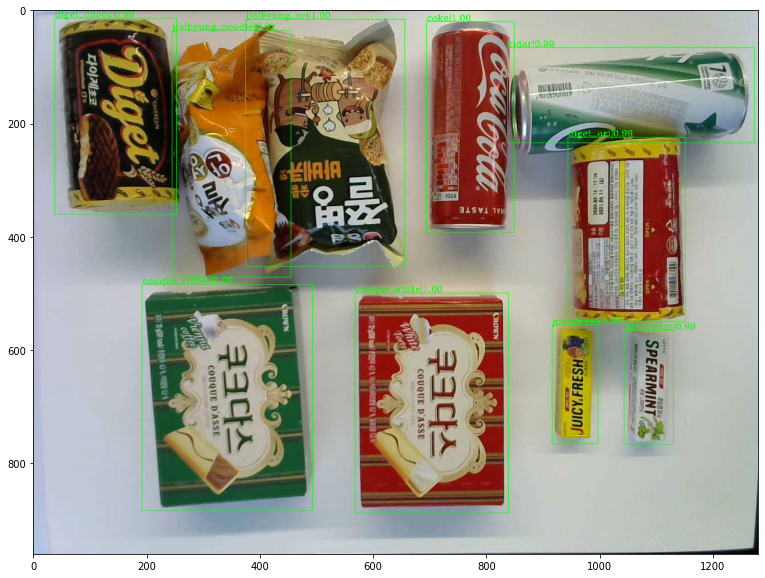

In [10]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('lotte_data/training/JPEGImages/0426.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)